In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 17 - The GCM model of categorization

## 17.1 The GCM model
The Generalized Context Model (GCM: Nosofsky, 1984, 1986) is an influential and empirically successful model of categorization. It is intended to explain how people make categorization decisions in a task where stimuli are presented, one at a time, over a sequence of trials, and must be classified into one of a small number of categories (usually two) based on corrective feedback.
The GCM assumes that stimuli are stored as exemplars, using their values along underlying stimulus dimensions, which correspond to points in a multidimensional psychological space. The GCM then assumes people make similarity comparisons between the current stimulus and the exemplars, and base their decision on the overall similarities to each category.

$$ c \sim \text{Uniform}(0,5) $$
$$ w \sim \text{Uniform}(0,1) $$  
$$ b = \frac{1}{2}$$  
$$ d_{ij}^m = \lvert p_{im} - p_{jm}\rvert $$  
$$ s_{ij} = \text{exp}[-c\,(w d^1_{ij}+(1-w)d^2_{ij})] $$  
$$ r_i = \frac{b \sum_{j}a_{j}s_{ij}}{b \sum_{j}a_{j}s_{ij}\,+\,(1-b) \sum_{j}(1-a_{j})s_{ij}}$$  
$$ y_i \sim \text{Binomial}(r_i,t)$$  

In [2]:
import scipy.io as sio
matdata = sio.loadmat('data/KruschkeData.mat')

nstim = 8
nsubj = 40
t = nstim*nsubj
a = matdata['a'][0]
y = matdata['y'][:,0]

d1 = matdata['d1']
d2 = matdata['d2']
x = matdata['x']

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 45.105:   6%|▌         | 12096/200000 [00:01<00:19, 9680.73it/s]
Convergence archived at 12100
Interrupted at 12,100 [6%]: Average Loss = 161.19
100%|██████████| 3500/3500.0 [00:03<00:00, 1158.73it/s]


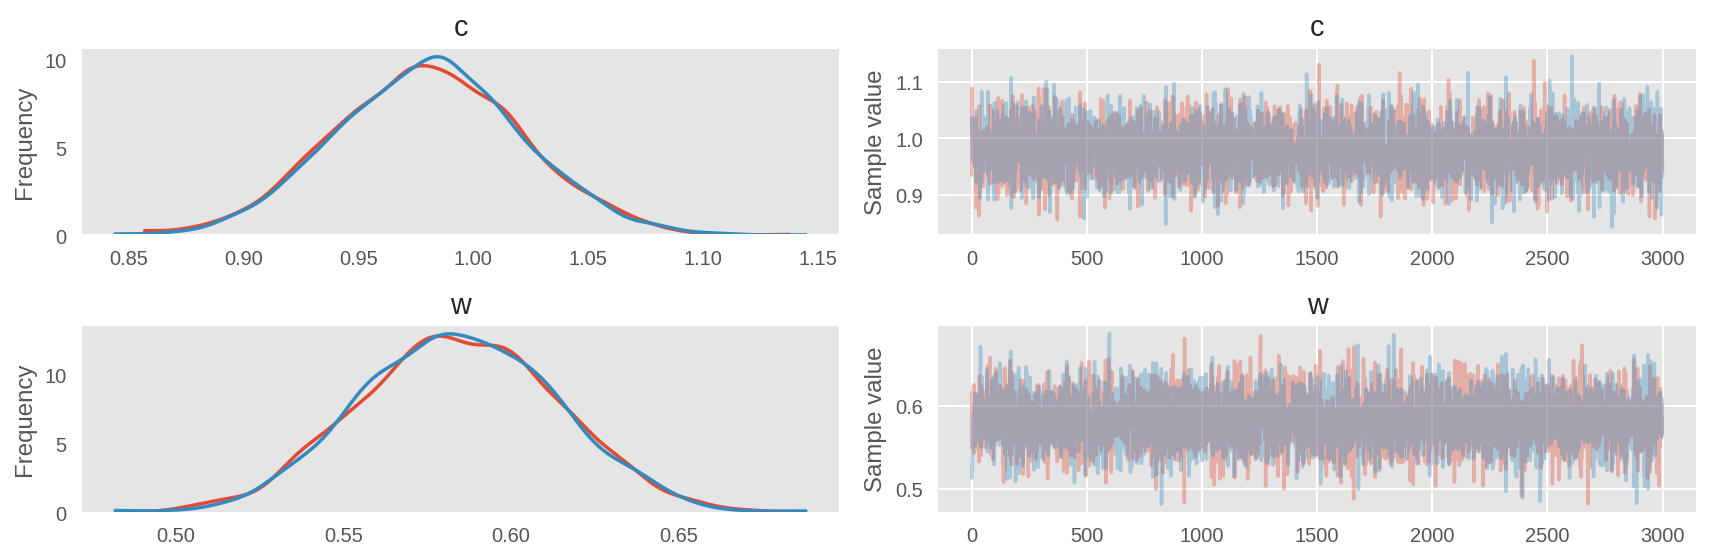

In [3]:
a1 = np.repeat(2-a, nstim).reshape(nstim, nstim).T

with pm.Model() as model1:
    c = pm.Uniform('c', lower=0, upper=5)
    w = pm.Uniform('w', lower=0, upper=1)
    b = .5
    sij = tt.exp(-c*(w*d1+(1-w)*d2))
    
    sum_ajsij = tt.sum(a1*sij, axis=1)
    sum_majsij = tt.sum((1-a1)*sij, axis=1)
    
    ri = pm.Deterministic('ri', (b*sum_ajsij)/(b*sum_ajsij+(1-b)*sum_majsij))
    yi = pm.Binomial('yi', p=ri, n=t, observed=y)
       
    trace1=pm.sample(3e3, njobs=2)

pm.traceplot(trace1, varnames=['c', 'w']);

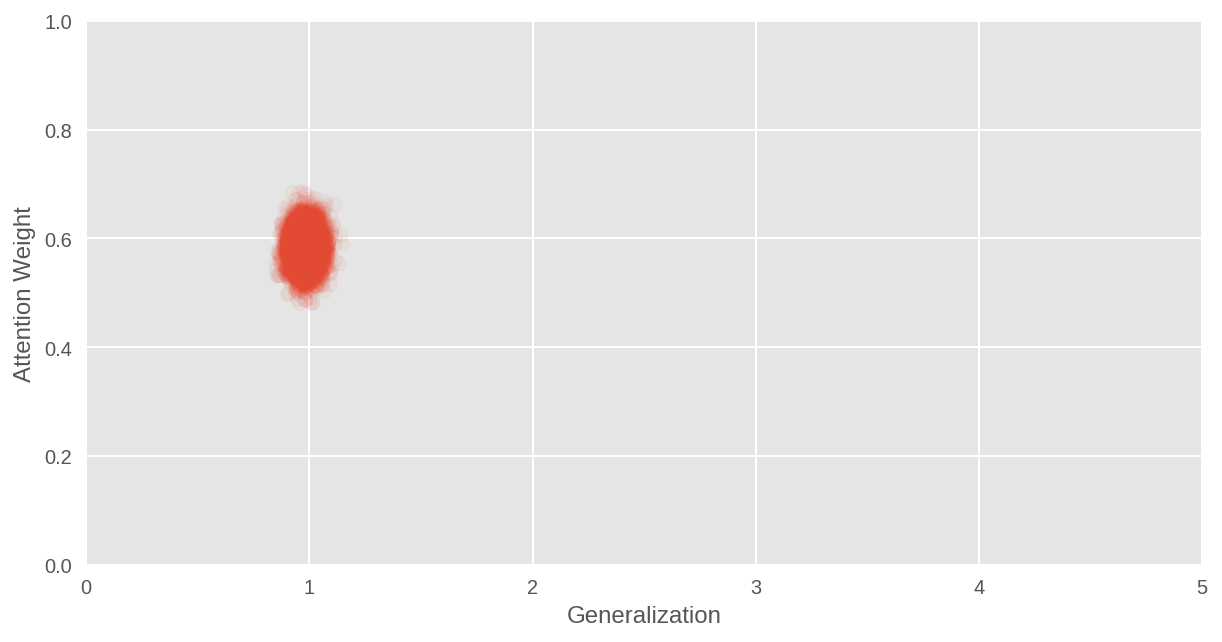

In [4]:
# Fig. 17.3
fig = plt.figure(figsize=(10, 5))
ctr = trace1['c']
wtr = trace1['w']
plt.scatter(ctr, wtr, alpha=.05)
plt.xlabel('Generalization')
plt.ylabel('Attention Weight')
plt.axis((0, 5, 0, 1))
plt.show()

100%|██████████| 500/500 [00:06<00:00, 82.63it/s]


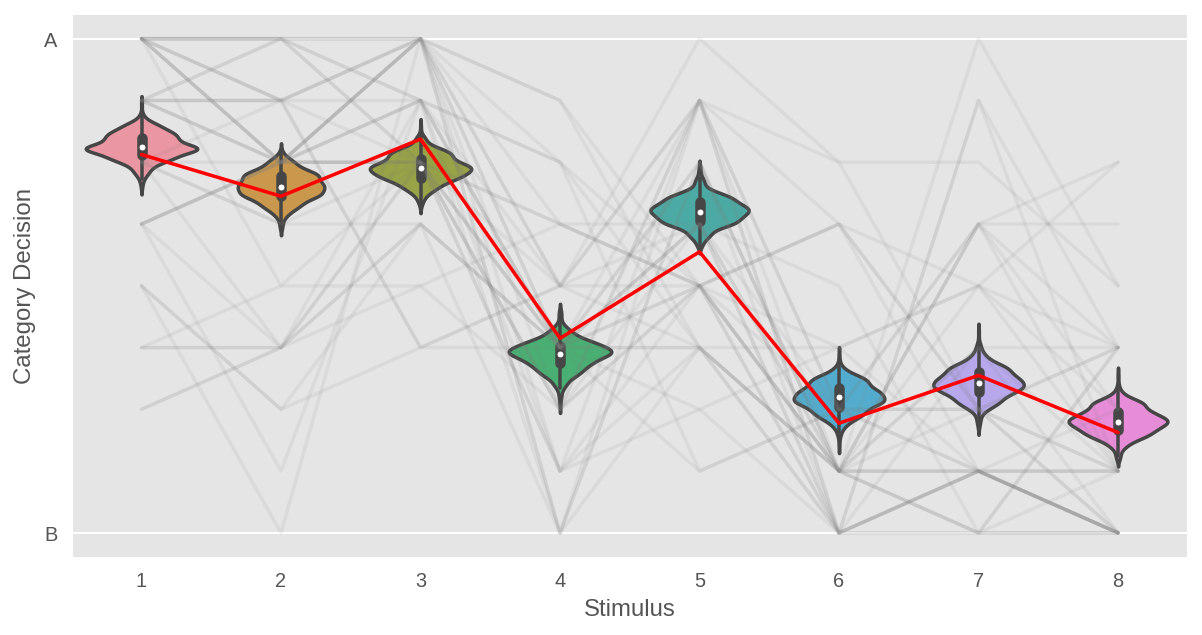

In [5]:
# Fig. 17.4
ppc = pm.sample_ppc(trace1, samples=500, model=model1)

fig = plt.figure(figsize=(10, 5))
yipred = ppc['yi']
ax = sns.violinplot(data=yipred)
plt.plot(np.float32(x).T*40, color='gray', alpha=.1)
plt.plot(np.mean(np.float32(x).T*40, axis=1), color='r', alpha=1)
plt.xticks(np.arange(8), ''.join(map(str, np.arange(1, 9))))
plt.yticks([0, t], ('B', 'A'))
plt.xlabel('Stimulus')
plt.ylabel('Category Decision')
plt.show()

## 17.2 Individual differences in the GCM


$$ c_k \sim \text{Uniform}(0,5) $$
$$ w_k \sim \text{Uniform}(0,1) $$  
$$ b_k = \frac{1}{2}$$  
$$ d_{ij}^m = \lvert p_{im} - p_{jm}\rvert $$  
$$ s_{ijk} = \text{exp}[-c_k\,(w_k d^1_{ij}+(1-w_k)d^2_{ij})] $$  
$$ r_{ik} = \frac{b_k \sum_{j}a_{j}s_{ijk}}{b_k \sum_{j}a_{j}s_{ijk}\,+\,(1-b_k) \sum_{j}(1-a_{j})s_{ijk}}$$  
$$ y_{ik} \sim \text{Binomial}(r_{ik},n)$$  

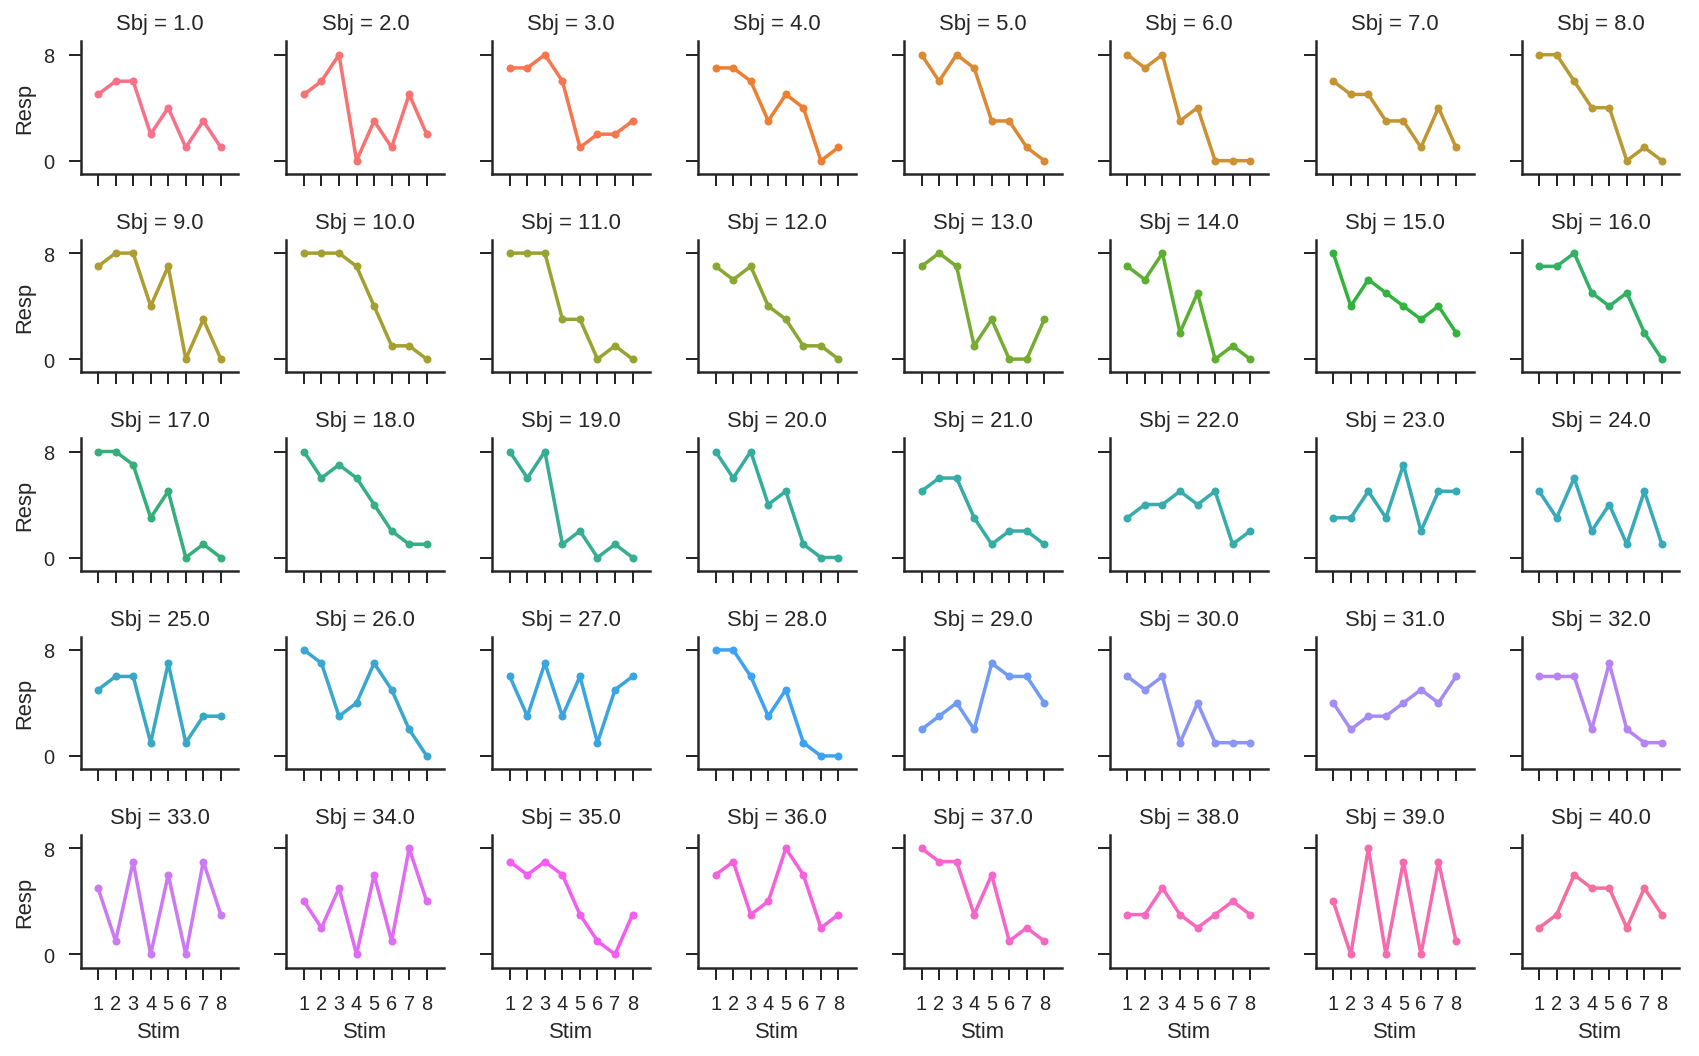

In [6]:
# Fig. 17.5
sns.set(style='ticks')

# Create a dataset with many short random walks
x2 = np.float32(x)
subjvect=[]
stimvect=[]
respvect=[]
for i in range(nstim):
    for j in range(nsubj):
        subjvect.append(j+1)
        stimvect.append(i+1)
        respvect.append(x2[j, i])
df = pd.DataFrame(np.c_[respvect, stimvect, subjvect],
                  columns=['Resp', 'Stim', 'Sbj'])

grid = sns.FacetGrid(df, col='Sbj', hue='Sbj', col_wrap=8, size=1.5)
grid.map(plt.plot, 'Stim', 'Resp', marker='o', ms=4)
# Adjust the tick positions and labels
grid.set(xticks=np.arange(1, 9), yticks=[0, 8],
         xlim=(0, 9), ylim=(-1, 9))
# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 620.94:   8%|▊         | 15855/200000 [00:03<00:39, 4631.81it/s]
Convergence archived at 16000
Interrupted at 16,000 [8%]: Average Loss = 728.31
100%|██████████| 3500/3500.0 [00:35<00:00, 97.29it/s] 


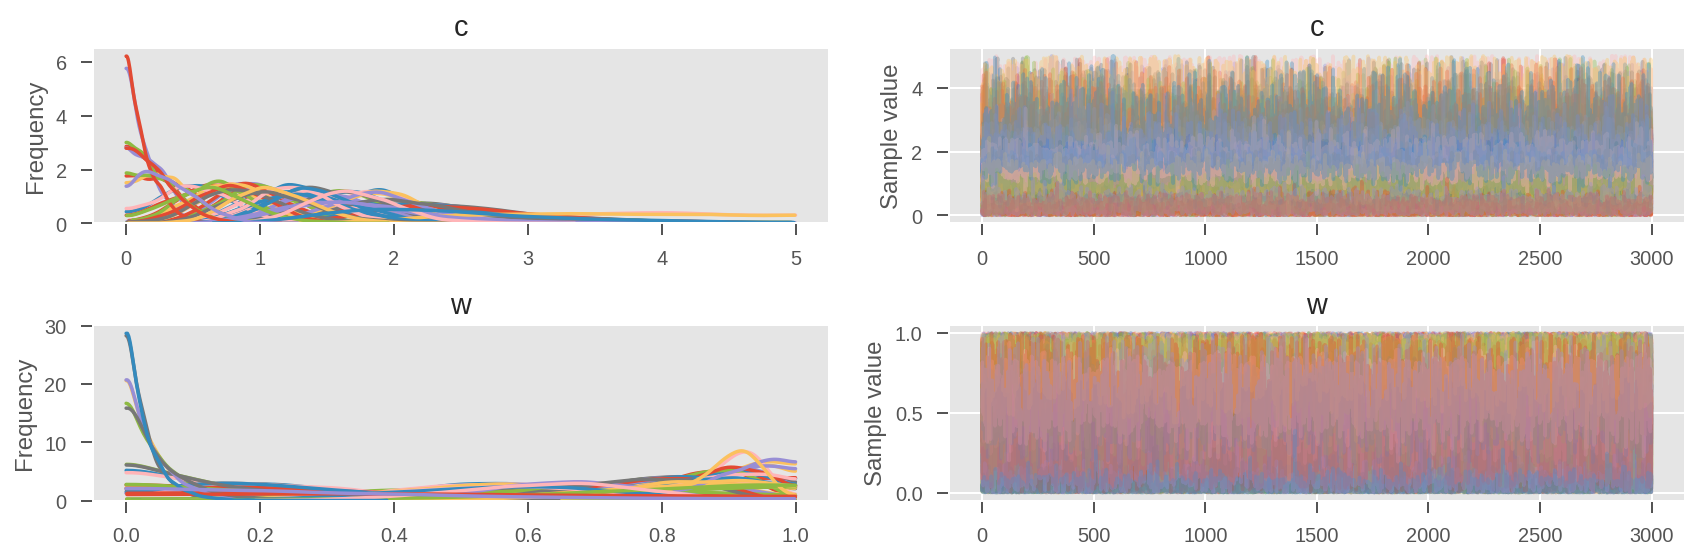

In [7]:
a1 = np.tile(2-a,[nstim,1])[:,:,np.newaxis]
y2 = x2.transpose()
d1_t = np.tile(d1[:, :, np.newaxis], [1, 1, nsubj])
d2_t = np.tile(d2[:, :, np.newaxis], [1, 1, nsubj])

with pm.Model() as model2:
    c = pm.Uniform('c', lower=0, upper=5, shape=(1, 1, nsubj))
    w = pm.Uniform('w', lower=0, upper=1, shape=(1, 1, nsubj))
    b = .5

    sij = tt.exp(-c*(w*d1_t+(1-w)*d2_t))
    
    sum_ajsij = tt.sum(a1*sij, axis=1)
    sum_majsij = tt.sum((1-a1)*sij, axis=1)
    
    ri = pm.Deterministic('ri', (b*sum_ajsij)/(b*sum_ajsij+(1-b)*sum_majsij))
    
    yi = pm.Binomial('yi', p=ri, n=nstim, observed=y2)
    
    trace2 = pm.sample(3e3, njobs=2)
    
plt.style.use('ggplot')
pm.traceplot(trace2, varnames=['c', 'w']);

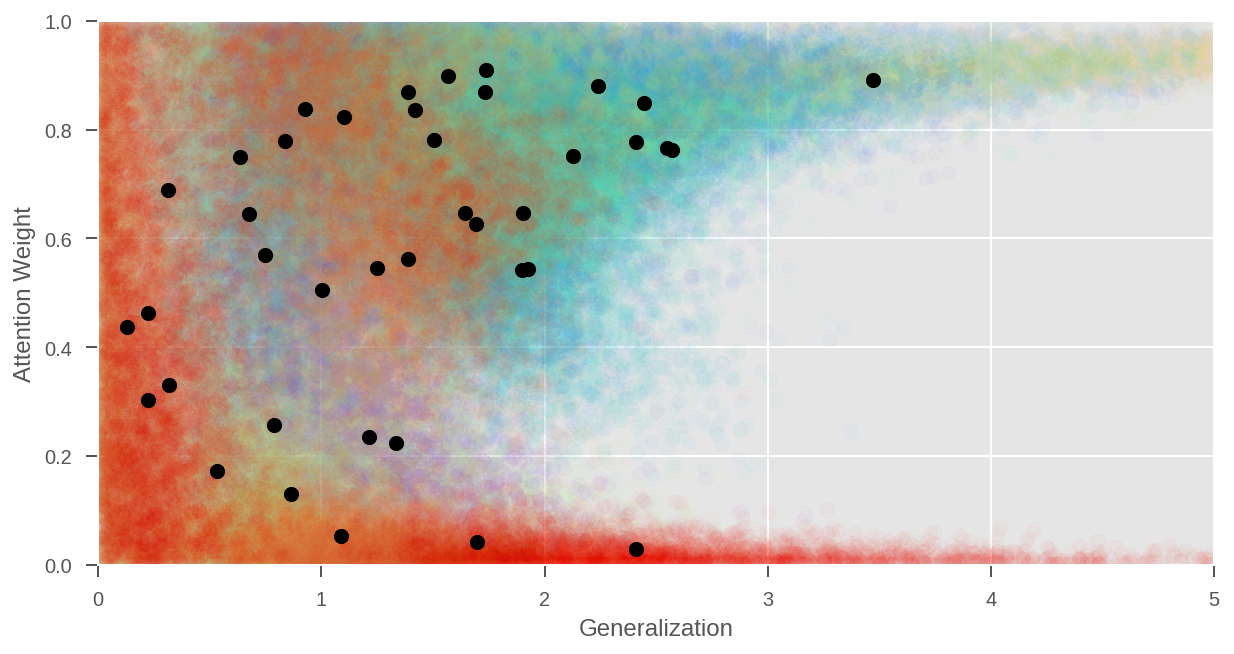

In [8]:
# Fig. 17.7
burnin=2500
fig = plt.figure(figsize=(10, 5))
ctr=np.squeeze(trace2['c'][burnin:])
wtr=np.squeeze(trace2['w'][burnin:])
from matplotlib import cm as cm
colors = cm.rainbow(np.linspace(0, 1, nsubj))
for i in range(nsubj):
    plt.scatter(ctr[:, i], wtr[:, i], color=colors[i], alpha=.025)
    
plt.scatter(np.mean(ctr, axis=0), np.mean(wtr, axis=0), s=50, color='black', alpha=1)
plt.xlabel('Generalization')
plt.ylabel('Attention Weight')
plt.axis((0, 5, 0, 1))
plt.show()

## 17.3 Latent groups in the GCM


$$ \mu_{1}^w,\delta \sim \text{Uniform}(0,1)$$
$$ \mu_{2}^w = \text{min}(1,\mu_{1}^w+\delta) $$
$$ \sigma^w \sim \text{Uniform}(0.01,1)$$
$$ \mu^c \sim \text{Uniform}(0,5)$$
$$ \sigma^c \sim \text{Uniform}(0.01,3)$$
$$ \phi^c,\phi^g \sim \text{Uniform}(0,1)$$
$$ z_{k}^c \sim \text{Bernoulli}(\phi^c)$$
$$ z_{k}^g \sim \text{Bernoulli}(\phi^g)$$

$$ c_k \sim \text{Gaussian}(\mu^c,\frac{1}{(\sigma^c)^2})_{\mathcal I(0,5)} $$
$$ w_k \sim
\begin{cases}
\text{Gaussian}(\mu_{1}^w,\frac{1}{(\sigma^w)^2})_{\mathcal I(0,1)}  & \text{if $z_{k}^c = 0,z_{k}^g = 0$} \\
\text{Gaussian}(\mu_{2}^w,\frac{1}{(\sigma^w)^2})_{\mathcal I(0,1)}  & \text{if $z_{k}^c = 0,z_{k}^g = 1$}
\end{cases}  $$

$$ b_k = \frac{1}{2}$$  
$$ d_{ij}^m = \lvert p_{im} - p_{jm}\rvert $$  
$$ s_{ijk} = \text{exp}[-c_k\,(w_k d^1_{ij}+(1-w_k)d^2_{ij})] $$  

$$ r_{ik} =
\begin{cases}
\frac{b_k \sum_{j}a_{j}s_{ijk}}{b_k \sum_{j}a_{j}s_{ijk}\,+\,(1-b_k) \sum_{j}(1-a_{j})s_{ijk}}  & \text{if $z_{k}^c = 0$} \\
\frac{1}{2}  & \text{if $z_{k}^c = 1$}
\end{cases}  $$


$$ y_{ik} \sim \text{Binomial}(r_{ik},n)$$  

In [9]:
# BoundNormal1 = pm.Bound(pm.Normal, lower=0., upper=5.)
# BoundNormal2 = pm.Bound(pm.Normal, lower=0., upper=1.)

with pm.Model() as model3:
    mu1w = pm.Uniform('mu1w', lower=0, upper=1, testval=.05)
    delta = pm.Uniform('delta', lower=0, upper=1, testval=.75)
    mu2w = pm.Deterministic('mu2w', tt.clip(mu1w+delta, 0, 1))
    
    sigmaw = pm.Uniform('sigmaw', lower=.01, upper=1, testval=.05)
    muc = pm.Uniform('muc', lower=0, upper=5, testval=1.4)
    sigmac = pm.Uniform('sigmac', lower=.01, upper=3, testval=.45)
    
    phic = pm.Uniform('phic', lower=0, upper=1, testval=.1)
    phig = pm.Uniform('phig', lower=0, upper=1, testval=.8)

    zck = pm.Bernoulli('zck', p=phic, shape=nsubj)
    zcg = pm.Bernoulli('zcg', p=phig, shape=nsubj)
#     zck_ = pm.theanof.tt_rng().uniform(size=(1, nsubj))
#     zck = pm.Deterministic('zck', tt.repeat(tt.lt(zck_, phic), nstim, axis=0))
#     zcg_ = pm.theanof.tt_rng().uniform(size=(nsubj,))
#     zcg = pm.Deterministic('zcg', tt.lt(zcg_, phig))
    b = .5
    
    # c = BoundNormal1('c', mu=muc, sd=sigmac, shape=(1, 1, nsubj))
    c = tt.clip(pm.Normal('c', mu=muc, sd=sigmac, shape=(1, 1, nsubj)), 0, 5)
    muw = pm.Deterministic('muw', tt.switch(tt.eq(zcg, 0), mu1w, mu2w))
    # w = BoundNormal2('w', mu=muw.all(), sd=sigmaw, shape=(1, 1, nsubj))
    w = tt.clip(pm.Normal('w', mu=muw, sd=sigmaw, shape=(1, 1, nsubj)), 0, 1)
    
    sij = tt.exp(-c*(w*d1_t+(1-w)*d2_t))
    
    sum_ajsij = tt.sum(a1*sij, axis=1)
    sum_majsij = tt.sum((1-a1)*sij, axis=1)
    
    ri1 = pm.Deterministic('ri1', (b*sum_ajsij)/(b*sum_ajsij+(1-b)*sum_majsij))
    ri2 = tt.constant(np.ones((nstim, nsubj))*.5)
    ri = pm.Deterministic('ri', tt.squeeze(tt.switch(tt.eq(zck, 0), ri1, ri2)))
    
    yi = pm.Binomial('yi', p=ri, n=nstim, observed=y2)

Assigned NUTS to mu1w_interval__
Assigned NUTS to delta_interval__
Assigned NUTS to sigmaw_interval__
Assigned NUTS to muc_interval__
Assigned NUTS to sigmac_interval__
Assigned NUTS to phic_interval__
Assigned NUTS to phig_interval__
Assigned BinaryGibbsMetropolis to zck
Assigned BinaryGibbsMetropolis to zcg
Assigned NUTS to c
Assigned NUTS to w
 98%|█████████▊| 3420/3500.0 [05:14<00:07, 10.89it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 3500/3500.0 [05:22<00:00, 11.35it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 10 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



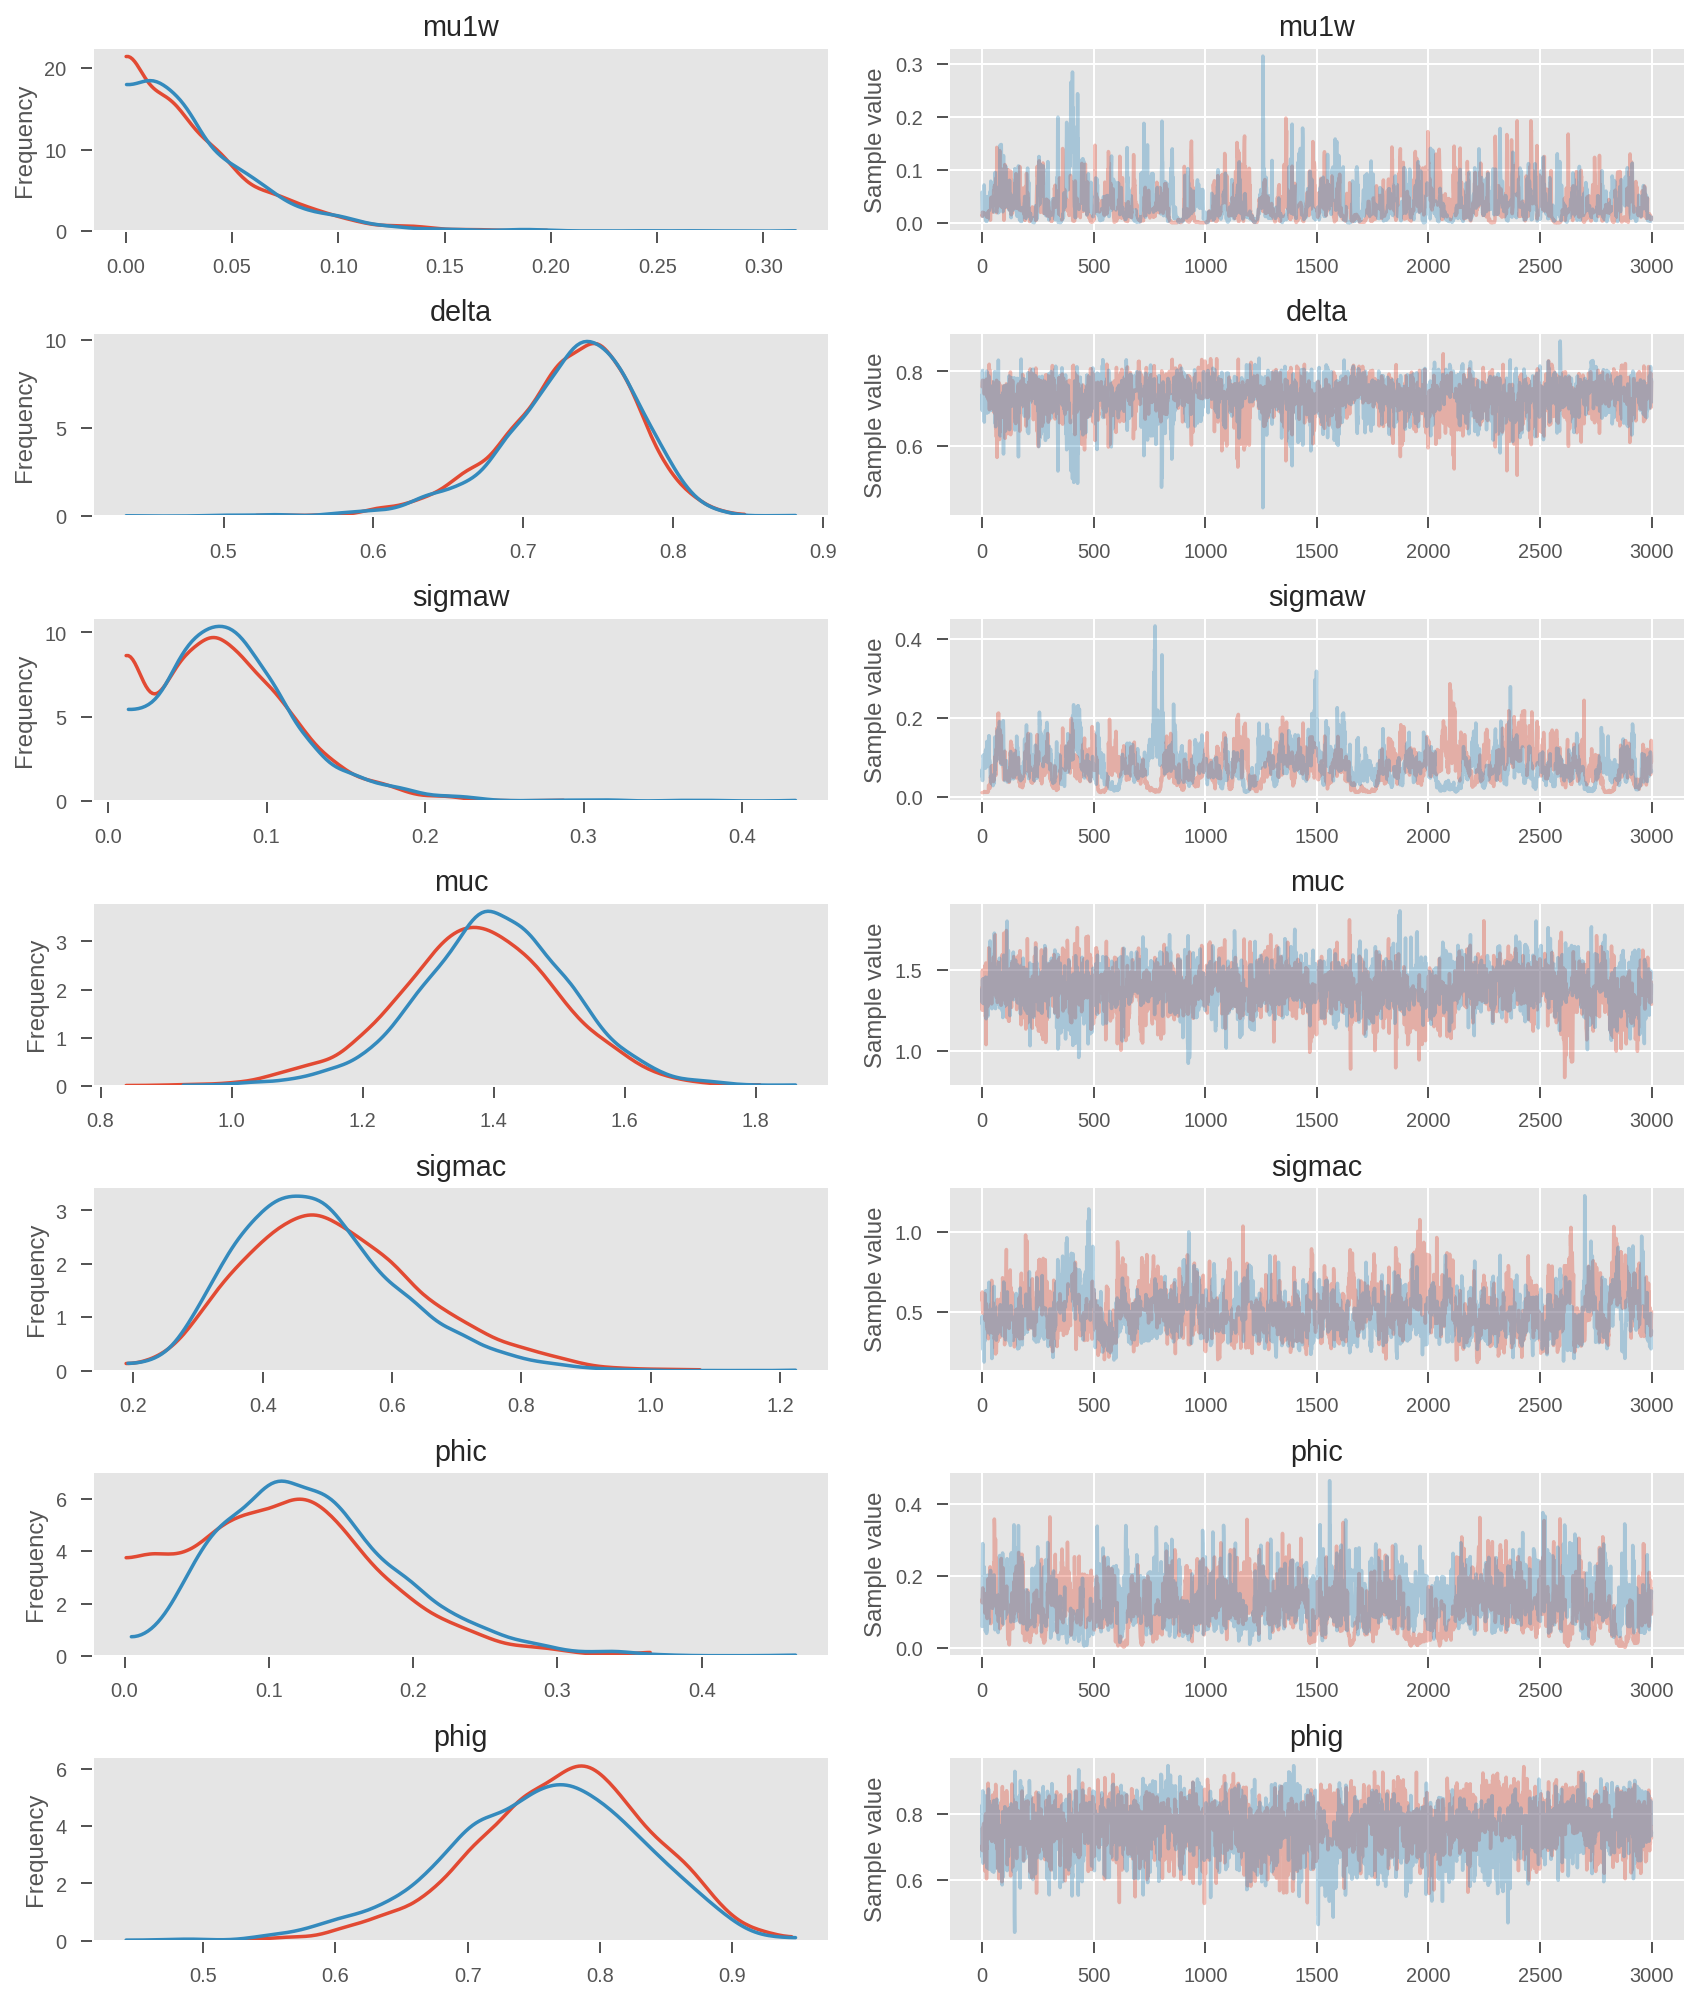

In [10]:
import theano
with model3:
    trace3 = pm.sample(3e3, njobs=2)

#     # Old ADVI api
#     v_params = pm.variational.advi(n=200000)
#     trace3 = pm.variational.sample_vp(v_params, 3000, progressbar=False,
#                                        hide_transformed=False)

#     # New ADVI api
#     s = theano.shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     # ADVI has nearly converged
#     inference.fit(n=20000)
#     # It is time to set `s` to zero
#     s.set_value(0)
#     approx = inference.fit(n=10000)
#     trace3 = approx.sample_vp(3000) 
#     elbos1 = -inference.hist

pm.traceplot(trace3, varnames=['mu1w', 'delta', 'sigmaw', 
                               'muc', 'sigmac', 
                               'phic', 'phig']);

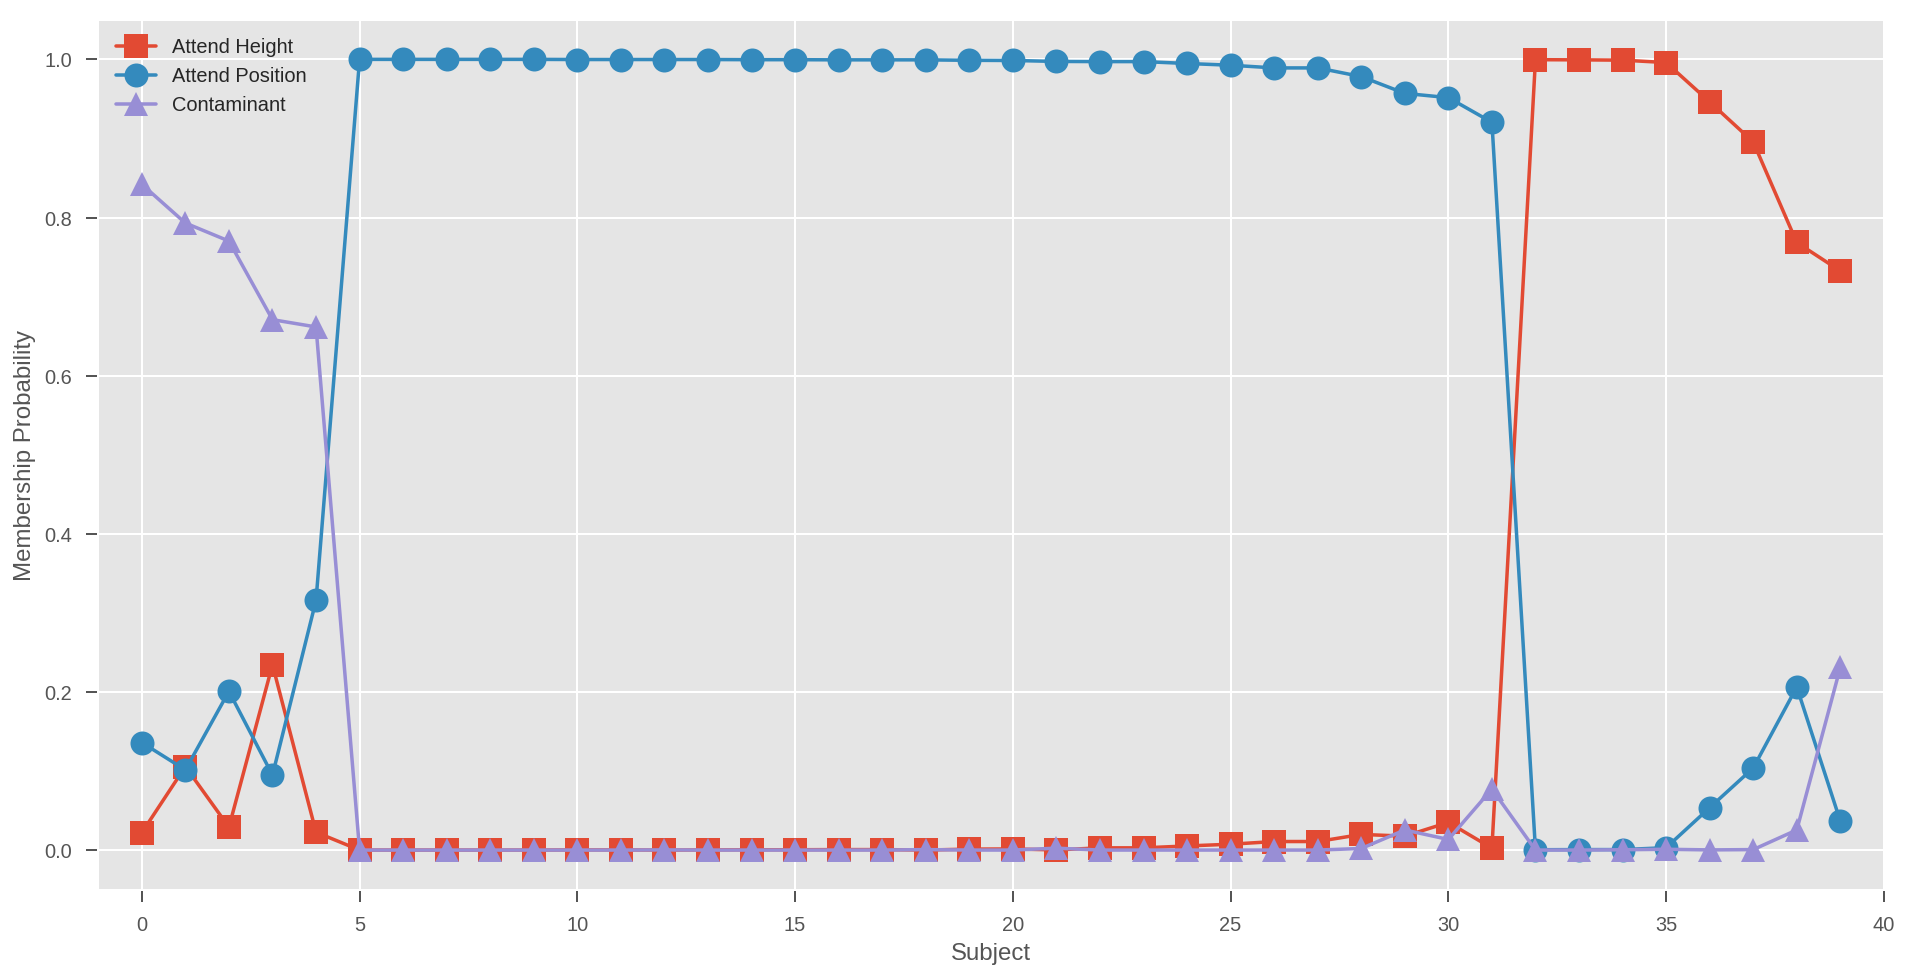

In [11]:
# Fig. 17.9
burnin = 1000
zc = np.squeeze(trace3['zck'][burnin:])
zg = np.squeeze(trace3['zcg'][burnin:])
z = (zc == 0) * (zg+1) + 3 * (zc == 1)
z1 = np.zeros((nsubj, 3))
for i in range(nsubj):
    sbjid = z[:, i]
    z1[i] = [np.sum(sbjid == 1)/len(sbjid), np.sum(sbjid == 2)/len(sbjid), np.sum(sbjid == 3)/len(sbjid)]
ord1 = []
for i in range(3):
    ordtmp = np.argsort(z1[:, i])
    ordtmp = ordtmp[z1[ordtmp, i] > .5]
    ord1.extend(ordtmp)
ord1 = np.asarray(ord1)
fig = plt.figure(figsize=(16, 8))

xpl = np.arange(40)[::-1]
plt.plot(xpl, z1[ord1, 0], marker='s', markersize=12)
plt.plot(xpl, z1[ord1, 1], marker='o', markersize=12)
plt.plot(xpl, z1[ord1, 2], marker='^', markersize=12)
plt.legend(['Attend Height', 'Attend Position', 'Contaminant'])
plt.ylim([-.05, 1.05])
plt.xlim([-1, 40])
plt.xlabel('Subject')
plt.ylabel('Membership Probability')
plt.show()

100%|██████████| 500/500 [00:14<00:00, 33.61it/s]


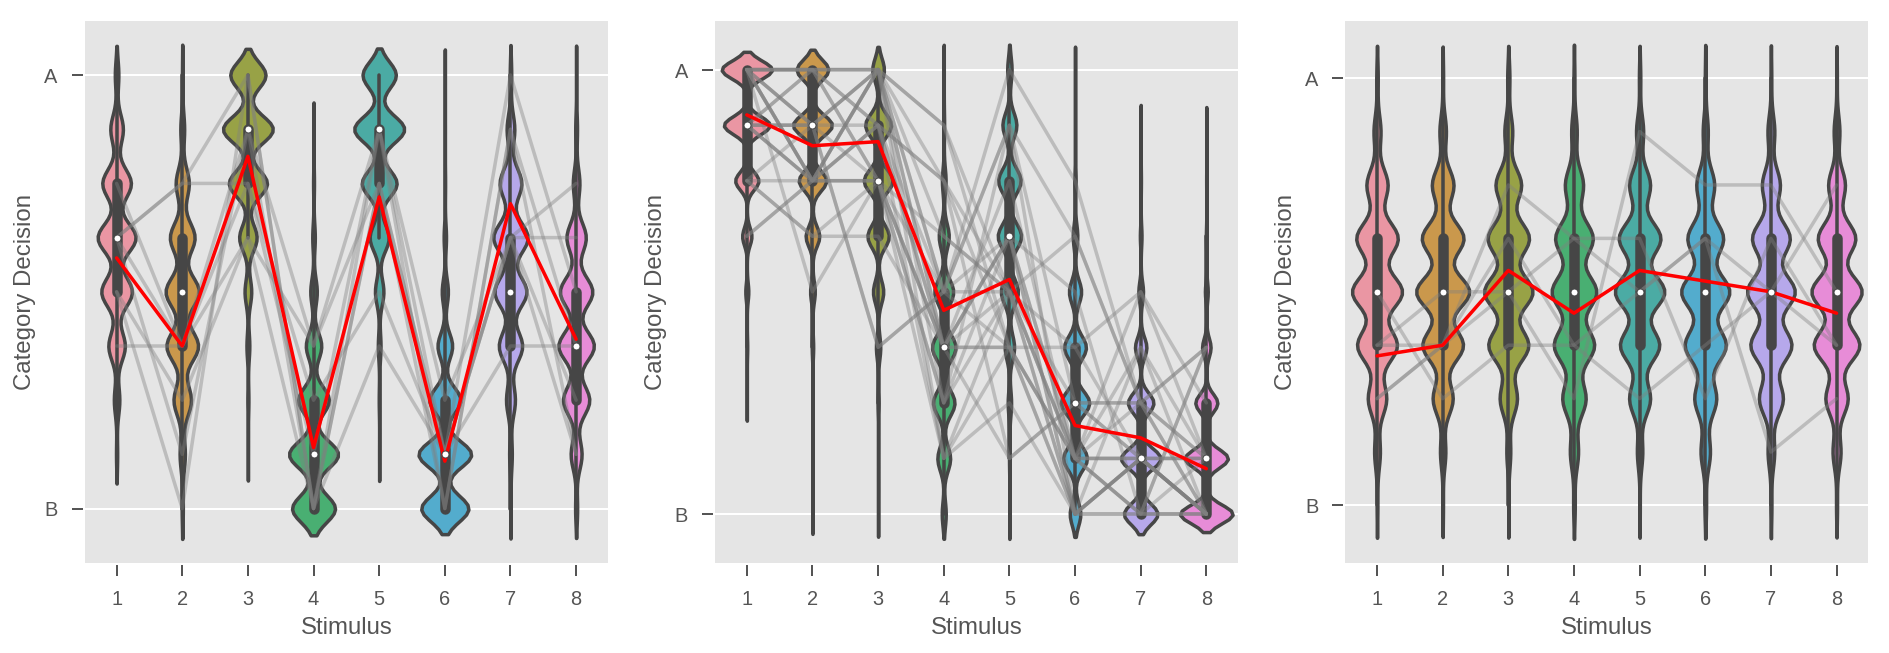

In [12]:
# Fig. 17.10
nppc_sample = 500
ppc = pm.sample_ppc(trace3[burnin:], samples=nppc_sample, model=model3)

fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 3)
for ip in range(3):
    ax = plt.subplot(gs[ip])
    idx = np.nonzero(z1[:, ip] > .5)[0]
    
    yipred = np.zeros((nppc_sample*len(idx), 8))
    for i, i2 in enumerate(idx):
        yipred1 = ppc['yi'][:, :, i2]
        yipred[0+i*nppc_sample:nppc_sample+i*nppc_sample, :] = yipred1
    
    ax = sns.violinplot(data=yipred)
    plt.plot(y2[:, idx], color='gray', alpha=.4)
    plt.plot(np.mean(y2[:, idx], axis=1), color='red', alpha=1)
    plt.xticks(np.arange(8), ''.join(map(str, np.arange(1, 9))))
    plt.yticks([0, nstim], ('B', 'A'))
    plt.xlabel('Stimulus')
    plt.ylabel('Category Decision')
plt.show()